# Carga y Limpieza de Datos

In [1]:
# Importo paquetes

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import sparse

In [2]:
X_train = sparse.load_npz("./Data/X_train_BoW.npz")
X_test = sparse.load_npz("./Data/X_test_BoW.npz")
y_train = pd.read_csv("./Data/y_train.csv", header=None)
y_test = pd.read_csv("./Data/y_test.csv", header=None)

In [3]:
y_train = y_train[0]
y_test = y_test[0]

In [10]:
X_train

<1424931x34378 sparse matrix of type '<class 'numpy.int64'>'
	with 5064539 stored elements in Compressed Sparse Row format>

# Modelado

In [5]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, roc_curve, roc_auc_score, auc
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb
import scipy.stats as st
from sklearn.externals import joblib

In [6]:
params = {"n_estimators": st.randint(500, 2000), # Number of boosted trees to fit.
            "max_depth": st.randint(5, 20),     # Maximum tree depth for base learners.
            "learning_rate": st.uniform(0.05, 0.4), #     Boosting learning rate (xgb’s “eta”)
            "colsample_bytree": st.beta(10, 1), #     Subsample ratio of columns when constructing each tree.
            "subsample": st.beta(10, 1),     # Subsample ratio of the training instance.
            "gamma": st.uniform(0, 10), #     Minimum loss reduction required to make a further partition on a leaf node of the tree.
            'reg_alpha': st.uniform(0.05,10),   # L1 regularization term on weights
            "min_child_weight": st.uniform(1,20), #    Minimum sum of instance weight(hessian) needed in a child.
          }

In [7]:
model = RandomizedSearchCV(lgb.LGBMClassifier(), params, n_iter = 20, scoring='roc_auc', verbose= 10, n_jobs=-1, cv=3, random_state=1)
print (model)
result = model.fit(X_train.astype('float32'), y_train.astype('float32'))

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
          fit_params=None, iid='warn', n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000010D250DFB38>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000010D250DFDA0>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000010D250FF048>, 'cols...A0>, 'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000010D250FFC88>},
          pre_dispatc

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 30.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 49.7min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 75.9min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 90.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 112.4min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 139.7min
[Parallel(n_jobs=-1)]: Done  52 out of  60 | elapsed: 153.0min remaining: 23.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 156.7min finished


In [11]:
print ("Mejor Modelo: ",result.best_estimator_)
print ("AUC: ",result.best_score_)
y_pred = result.predict(X_test.astype('float32'))
print ("Matriz de Confusión:\n",confusion_matrix(y_test, y_pred))
print ("Accuracy: ",accuracy_score(y_test, y_pred))
print ("Recall: ",recall_score(y_test, y_pred))
print ("Precision: ",precision_score(y_test, y_pred),"\n")
y_probs = result.predict_proba(X_test.astype('float32'))[:,1]

Mejor Modelo:  LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.814884396584042, gamma=1.954294811093188,
        importance_type='split', learning_rate=0.2825435709093031,
        max_depth=8, min_child_samples=20,
        min_child_weight=2.0003617177648527, min_split_gain=0.0,
        n_estimators=1378, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=2.4484775914758616, reg_lambda=0.0,
        silent=True, subsample=0.916937654241792, subsample_for_bin=200000,
        subsample_freq=0)
AUC:  0.8418150792578332
Matriz de Confusión:
 [[600743    767]
 [ 18890    973]]
Accuracy:  0.9683652170274537
Recall:  0.048985551024517945
Precision:  0.5591954022988506 



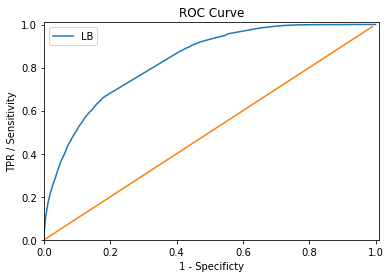

In [13]:
fpr_LB,tpr_LB,thr_LB = roc_curve(y_test, y_probs)

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')
plt.plot(fpr_LB,tpr_LB)
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.legend(['LB'])
plt.show()

In [14]:
print('AUC-LB=', auc(fpr_LB, tpr_LB))

AUC-LB= 0.8330158317697621


In [16]:
joblib.dump(result, './Modelos/BoW/BoW_LGBM_optimizado.sav')

['./Modelos/BoW/BoW_LGBM_optimizado.sav']